In [6]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal


# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")


## Speech recognition

In [2]:
audio_path = "audio_preproc/180923214834-Y20UOTIE-text-000_pp.wav"
Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if "model" not in locals():
    model = Model(model_path)

i skymningen en mycket het dag i början av juli lämnade en ung man sin kammare som han hörde vid s grand steg ut på gatan och började långsamt och med samma obeslutsam går bort mot jobb men lyckligtvis slapp han möter värdinnan i kappan hans kammare som låg alldeles in under den höga fem veckor aning speglar minst ha liknande snart ska jag köpa en bostad värdinnan som hyrde ut vind skutan och höll honom med middag som jag mål och städning bodde för sig i en våningen trappar trappa ner och när han skulle ut måste hem passera värdinnan kex ingång där döden nästan alltid sture


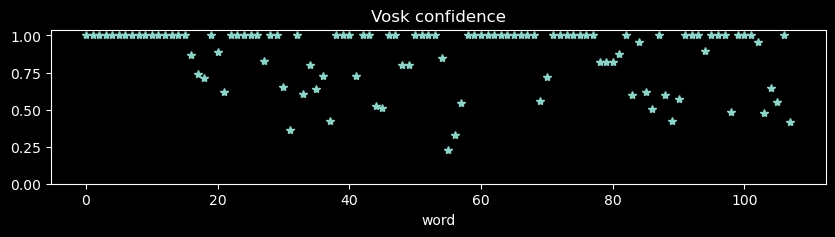

In [3]:
words = tools.rec_vosk(audio_path, model, print_summary=False)

text = " ".join([w["word"] for w in words])


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [5]:
# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)

for w in words:
    print(w["word"], w["vowels"], str(w["conf"]*100) + '%')

i ['i'] 100.0%
skymningen ['y', 'i', 'e'] 100.0%
en ['e'] 100.0%
mycket ['y', 'e'] 100.0%
het ['e'] 100.0%
dag ['a'] 100.0%
i ['i'] 100.0%
början ['ö', 'a'] 100.0%
av ['a'] 100.0%
juli ['u', 'i'] 100.0%
lämnade ['ä', 'a', 'e'] 100.0%
en ['e'] 100.0%
ung ['u'] 100.0%
man ['a'] 100.0%
sin ['i'] 100.0%
kammare ['a', 'a', 'e'] 100.0%
som ['o'] 87.0963%
han ['a'] 73.7355%
hörde ['ö', 'e'] 70.9958%
vid ['i'] 100.0%
s [] 88.9228%
grand ['a'] 61.631499999999996%
steg ['e'] 100.0%
ut ['u'] 100.0%
på ['å'] 100.0%
gatan ['a', 'a'] 100.0%
och ['o'] 100.0%
började ['ö', 'a', 'e'] 82.7056%
långsamt ['å', 'a'] 100.0%
och ['o'] 100.0%
med ['e'] 65.5248%
samma ['a', 'a'] 36.3617%
obeslutsam ['o', 'e', 'u', 'a'] 100.0%
går ['å'] 60.600500000000004%
bort ['o'] 80.4134%
mot ['o'] 63.9351%
jobb ['o'] 72.6825%
men ['e'] 42.125099999999996%
lyckligtvis ['y', 'i', 'i'] 100.0%
slapp ['a'] 100.0%
han ['a'] 100.0%
möter ['ö', 'e'] 72.7627%
värdinnan ['ä', 'i', 'a'] 100.0%
i ['i'] 100.0%
kappan ['a', 'a'] 52.2185

## test 1 word

In [ ]:
def HNR_short(audio, Fs, n_peaks = -1):
    fl = int(0.02 * Fs)
    frames, f_start = tools.split_frames(audio, fl, Fs, overlap=0, print_info=True)
    hnr_frames = np.array([get_HNR(f, Fs) for f in frames])
    peaks, peaks_prop = signal.find_peaks(hnr_frames)
    peaks = peaks[(-peaks).argsort()[:n_peaks-1]] #läskig one-liner
    return peaks, hnr_frames, f_start



skymningen
----------
frame length    : 882 samples
frame length    : 0.02 seconds
between frames  : 0.02 seconds
number of frames: 41


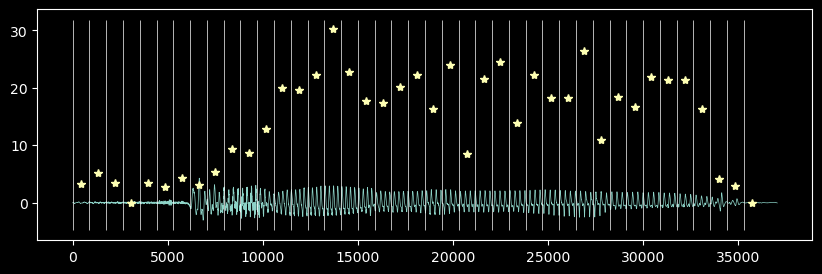

In [45]:
k = 1
print(words[k]["word"])
print("-" * len(words[k]["word"]))
segments, vowels_per_segment = tools.segment_by_words(words, audio, Fs, tools.VOWELS_SV)
x = segments[k] / segments[k].std()

fl = int(0.02 * Fs)
frames, f_start = tools.split_frames(x, fl, Fs, overlap=0, print_info=True)
hnr_frames = np.array([get_HNR(f, Fs) for f in frames])
plt.figure(figsize=(10, 3))
plt.plot(x)
plt.plot(f_start + int(fl / 2), hnr_frames, "*")
plt.vlines(f_start, *plt.ylim())

plt.show()
